C:\Users\Jakub\AppData\Local\Temp\ipykernel_6260\3688294912.py:40: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


rows 958524


<AxesSubplot:>

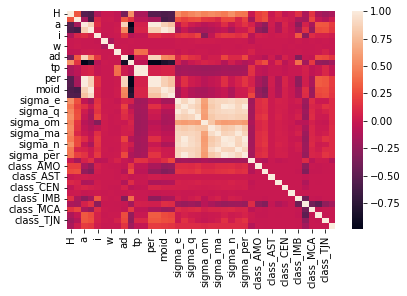

In [1]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from collections import Counter

sns.reset_orig()

noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

np.random.seed(seed)
data = pd.read_csv('dataset.csv')
print('rows', len(data))
data = data.drop(
    columns=['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'orbit_id', 'equinox', 'epoch', 'epoch_cal',
             'epoch_mjd', 'diameter', 'diameter_sigma', 'albedo'])
# data = data[data['neo'].notna()]
len(data)


def winsorize(df, exclude):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name not in exclude:
            if df[feature_name].dtype == 'float64' or df[feature_name].dtype == 'int32' or df[
                feature_name].dtype == 'int64':
                q1 = df[feature_name].quantile(0.25)
                q3 = df[feature_name].quantile(0.75)

                iqr = q3 - q1

                lower_bound = q1 - (1.5 * iqr)
                upper_bound = q3 + (1.5 * iqr)

                df.loc[df[feature_name] < lower_bound, feature_name] = lower_bound
                df.loc[df[feature_name] > upper_bound, feature_name] = upper_bound
    return df


def normalize(df, exclude):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name not in exclude:
            if df[feature_name].dtype == 'float64' or df[feature_name].dtype == 'int32':
                max_value = df[feature_name].max()
                min_value = df[feature_name].min()
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


data = winsorize(data, ['neo', 'pha', 'class'])
data = normalize(data, ['neo', 'pha', 'class'])

data_neo = data[data['neo'].notna()].drop(columns=['pha'])
data_pha = data[data['pha'].notna()].drop(columns=['neo'])


# data_neo = data_neo.fillna(values=data_neo.mean(), axis=1)

def my_fill_mean(df):
    for i in df.columns[df.isnull().any(axis=0)]:
        df[i].fillna(df[i].mean(), inplace=True)


my_fill_mean(data_neo)
my_fill_mean(data_pha)

data_neo.loc[data_neo['neo'] == 'N', 'neo'] = 0
data_neo.loc[data_neo['neo'] == 'Y', 'neo'] = 1

data_neo = data_neo.reset_index(drop=True)

data_pha.loc[data_pha['pha'] == 'N', 'pha'] = 0
data_pha.loc[data_pha['pha'] == 'Y', 'pha'] = 1

data_pha = data_pha.reset_index(drop=True)

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
# classes = data_neo['class'].values
# classes = classes.reshape(-1, 1)

encoded_class = pd.DataFrame(enc.fit_transform(data_neo[['class']]))
encoded_class.columns = enc.get_feature_names_out()
data_neo = data_neo.drop(columns=['class']).join(encoded_class)

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
# classes = data_neo['class'].values
# classes = classes.reshape(-1, 1)

encoded_class = pd.DataFrame(enc.fit_transform(data_pha[['class']]))
encoded_class.columns = enc.get_feature_names_out()
data_pha = data_pha.drop(columns=['class']).join(encoded_class)

sns.heatmap(data_neo.corr())

In [2]:
from sklearn.tree import DecisionTreeClassifier


class MyRandomForest:
    def __init__(self, n_estimators, min_samples_split, max_depth):
        self.n_estimators = n_estimators
        self.min_sample_split = min_samples_split
        self.max_depth = max_depth
        self.estimators = []
        pass

    def fit(self, X, y):
        self.estimators = [DecisionTreeClassifier(min_samples_split=self.min_sample_split, max_depth=self.max_depth) for _ in range(self.n_estimators)]

        mydata = np.column_stack((X, y))

        for e in self.estimators:
            sample_idx = np.random.choice(X.shape[0], X.shape[0])
            # print(X.shape[0])
            # print(sample_idx)
            e.fit(X[sample_idx], y[sample_idx])

        pass


    def predict(self, X):
        all = []
        for e in self.estimators:
            all.append([int(xxx) for xxx in e.predict(X)])
        all = np.array(all).T

        return np.array([np.argmax(np.bincount(pred)) for pred in all])

In [3]:
def tree_function(mdl, X_tr, y_tr, X_te, y_te, silent=False):

    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_test)

    if not silent:

        cm_model = confusion_matrix(y_test, y_pred)
        tn_model = cm_model[0][0]
        fn_model = cm_model[0][1]
        tp_model = cm_model[1][1]
        fp_model = cm_model[1][0]
        ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

        fpr, tpr, roc_auc = roc_curve(y_test, mdl.predict(X_test))

        rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
        rok_model.plot()


        print("Czulosc:", tp_model/(tp_model + fn_model))
        print("Swoistosc:", tn_model/(tn_model + fp_model))
        print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

        print("ROC auc:", roc_auc_score(y_test, y_pred))
        print("F1 score:", f1_score(y_test, y_pred))
        print("BA score:", balanced_accuracy_score(y_test, y_pred))



In [4]:
X = data_neo.drop(axis=1, columns=['neo']).to_numpy()
y = data_neo['neo'].to_numpy().astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=seed, shuffle=True)

Czulosc: 1.0
Swoistosc: 0.9967399121054734
Accuracy: 0.9968075783499561
ROC auc: 0.9333478544979308
F1 score: 0.928588098016336
BA score: 0.9333478544979308
Czas sklearn dla glebokosci 1:  47.235940099999425


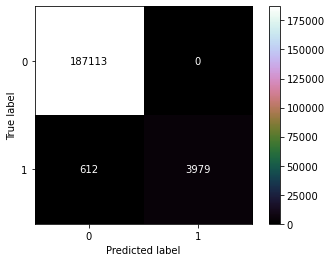

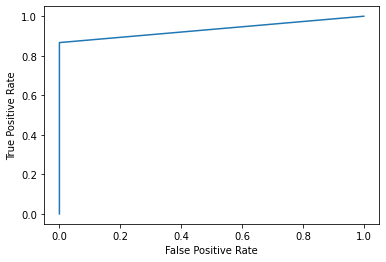

In [5]:
ttime = time.perf_counter()

# for _ in range(4):
#     model = RandomForestClassifier(n_estimators=100, max_depth=1)
#     tree_function(model, X_train, y_train, X_test, y_test, True)

model = RandomForestClassifier(n_estimators=100, max_depth=1)
tree_function(model, X_train, y_train, X_test, y_test, False)

print('Czas sklearn dla glebokosci 1: ', time.perf_counter() - ttime)


Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0
Czas mojego dla glebokosci 1:  361.60197640000115


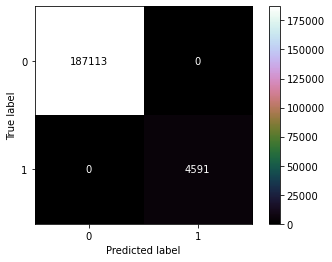

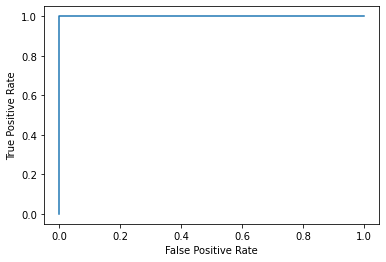

In [6]:
ttime = time.perf_counter()

# for _ in range(4):
#     model = MyRandomForest(n_estimators=100, max_depth=1, min_samples_split=2)
#     tree_function(model, X_train, y_train, X_test, y_test, True)

model = MyRandomForest(n_estimators=100, max_depth=1, min_samples_split=2)
tree_function(model, X_train, y_train, X_test, y_test, False)

print('Czas mojego dla glebokosci 1: ', time.perf_counter() - ttime)


Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0
Czas sklearn dla glebokosci 1000:  160.2068991999986


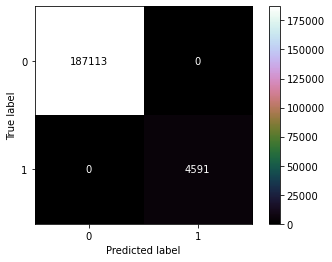

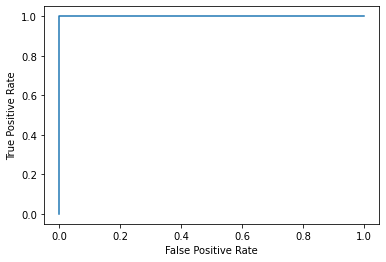

In [7]:
ttime = time.perf_counter()

# for _ in range(4):
#     model = RandomForestClassifier(n_estimators=100, max_depth=1000)
#     tree_function(model, X_train, y_train, X_test, y_test, True)

model = RandomForestClassifier(n_estimators=100, max_depth=1000)
tree_function(model, X_train, y_train, X_test, y_test, False)

print('Czas sklearn dla glebokosci 1000: ', time.perf_counter() - ttime)


Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0
Czas mojego dla glebokosci 1000:  351.7676085000021


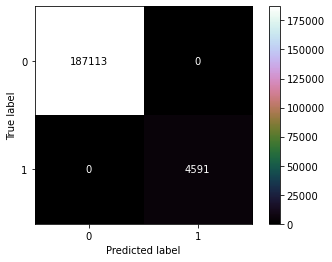

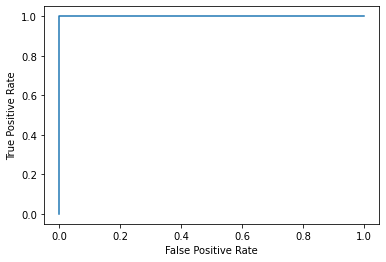

In [8]:
ttime = time.perf_counter()

# for _ in range(4):
#     model = MyRandomForest(n_estimators=100, max_depth=1000, min_samples_split=2)
#     tree_function(model, X_train, y_train, X_test, y_test, True)

model = MyRandomForest(n_estimators=100, max_depth=1000, min_samples_split=2)
tree_function(model, X_train, y_train, X_test, y_test, False)

print('Czas mojego dla glebokosci 1000: ', time.perf_counter() - ttime)


Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0
Czas sklearn dla glebokosci 1000000:  166.5848651999986


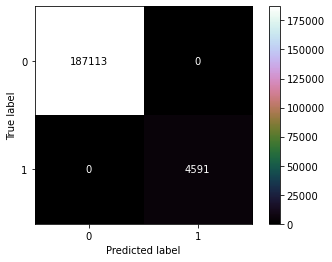

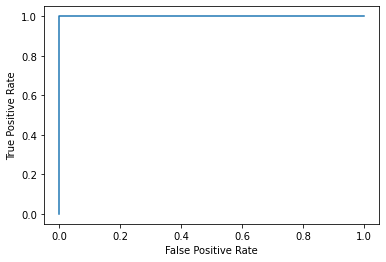

In [9]:
ttime = time.perf_counter()

# for _ in range(4):
#     model = RandomForestClassifier(n_estimators=100, max_depth=len(X_train))
#     tree_function(model, X_train, y_train, X_test, y_test, True)

model = RandomForestClassifier(n_estimators=100, max_depth=len(X_train))
tree_function(model, X_train, y_train, X_test, y_test, False)

print('Czas sklearn dla glebokosci 1000000: ', time.perf_counter() - ttime)


Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0
Czas mojego dla glebokosci 1000000:  344.2914402999995


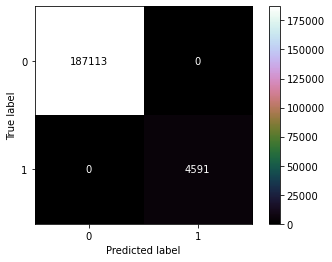

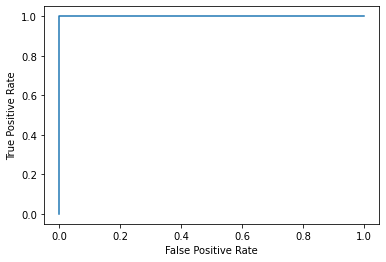

In [12]:
ttime = time.perf_counter()

# for _ in range(4):
#     model = MyRandomForest(n_estimators=100, max_depth=len(X_train), min_samples_split=2)
#     tree_function(model, X_train, y_train, X_test, y_test, True)

model = MyRandomForest(n_estimators=100, max_depth=len(X_train), min_samples_split=2)
tree_function(model, X_train, y_train, X_test, y_test, False)

print('Czas mojego dla glebokosci 1000000: ', time.perf_counter() - ttime)


Wnioski

Zlozonosc obliczeniowa nie pozwolila na pomiar 5 uruchomien algorytmu. Optymalna wysokosc lasu wplywa pozytywnie na jego wyniki klasyfikacji, jednakze przy prawie milionie rekordow w tym zbiorze danych, nie ma to wplywu na klasyfikacja oraz ma maly wplyw na czas obliczeniowy.

In [14]:
 ! jupyter nbconvert --to html lab6cz3.ipynb

[NbConvertApp] Converting notebook lab6cz3.ipynb to html
[NbConvertApp] Writing 761283 bytes to lab6cz3.html
